In [1]:
import urllib
from pathlib import Path

In [26]:
mnist_test_set_url = (
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
)
response = urllib.request.urlopen(mnist_test_set_url)
response

In [27]:
mnist_path = Path.cwd()/mnist_test_set_url.split("/")[-1]
with open(mnist_path, "wb") as f:
    f.write(response.read())
print(f'The gzip file is downloaded at {mnist_path.absolute()}')

The gzip file is downloaded at /home/phunc20/git-repos/github/phunc20/python/base64/t10k-images-idx3-ubyte.gz


Let's take **the first 3 images** from this test set.

In [10]:
import gzip

In [16]:
f = gzip.open(mnist_path)

In [17]:
import struct

In [20]:
header_bytes = f.read(16)
magic, n_test_images, n_rows, n_cols = struct.unpack('>4i', header_bytes)
print(f'{magic, n_images, n_rows, n_cols = }')

magic, n_images, n_rows, n_cols = (0, 0, 0, 0)


In [91]:
import gzip
import struct

import numpy as np

n_images = 3
#bX_new = []
X_new = []
float_type = np.float32
with gzip.open(mnist_path) as f:
    n_header_bytes = 16
    bheader = f.read(n_header_bytes)
    magic, n_test_images, n_rows, n_cols = struct.unpack(">4i", bheader)
    # n_rows, n_cols refer to height and width of MNIST images
    # Each MNIST image is a single-channel image
    # Each pixel is represented by uint8, i.e. 1 byte
    n_image_bytes = n_rows*n_cols
    for i in range(n_images):
        bimage = f.read(n_image_bytes)
        image = np.frombuffer(bimage, dtype=np.uint8).reshape((n_rows, n_cols, 1))
        image = (image / 255.).astype(float_type)
        #bX_new.append(bimage)
        X_new.append(image)

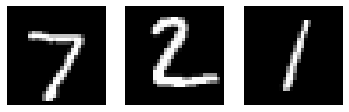

In [95]:
import matplotlib.pyplot as plt

X_new = np.array(X_new)
fig, ax = plt.subplots(1,3)
for i in range(n_images):
    ax[i].imshow(X_new[i], cmap="gray")
    ax[i].axis("off")

## REST API Example for Tensorflow Serving

### Sender

In [96]:
import json

In [97]:
def template(instances):
    return {"signature_name": "serving_default",
            "instances": instances,
           }

In [98]:
simplest_template = template(X_new.tolist())
input_data_json = json.dumps(simplest_template)
print(f'{type(input_data_json) = }')
# print(f'{input_data_json = }')

type(input_data_json) = <class 'str'>


In [99]:
import sys

print(f'{len(input_data_json)           = :,d}')
print(f'{sys.getsizeof(input_data_json) = :,d}')

len(input_data_json)           = 21,862
sys.getsizeof(input_data_json) = 21,911


In [100]:
import base64

# It doesn't really matter to choose btw ASCII and UTF-8 here
# because base64 only encodes to ASCII characters.
# codec = "ascii"
codec = "utf-8"
instances = [
    base64.b64encode(image.tobytes()).decode(codec)
    for image in X_new
]
base64_template = template(instances)
another_input_data_json = json.dumps(base64_template)

In [101]:
print(f'{len(another_input_data_json)           = :,d}')
print(f'{sys.getsizeof(another_input_data_json) = :,d}')

len(another_input_data_json)           = 12,616
sys.getsizeof(another_input_data_json) = 12,665


Reduced to almost one half.

### Receiver

In [102]:
response = json.loads(another_input_data_json)

In [103]:
instances = response["instances"]

In [104]:
X_restored = [
    np.frombuffer(
        base64.b64decode(s.encode(codec)), dtype=float_type
    ).reshape((n_rows, n_cols, 1))
    for s in instances
]

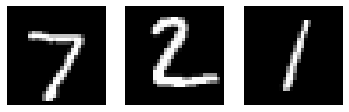

In [105]:
fig, ax = plt.subplots(1,3)
for i in range(n_images):
    ax[i].imshow(X_restored[i], cmap="gray")
    ax[i].axis("off")

## Q&A

1. How did we know that there were 16 bytes for the header part?
    - Because [The MNIST database page](http://yann.lecun.com/exdb/mnist/) says so.
1. Is there a more efficient NumPy function for
   > Create a list, append it with, say, 3 ndarrays, and finally make the outmost list an ndarray itself

## Ref.
- [The MNIST database](http://yann.lecun.com/exdb/mnist/)
- [Alessandro Nicolosi's post](https://alenic.github.io/snippets/2021/02/08/mnist-loader-python.html)